In [0]:
!pip install pybullet

In [0]:
import gym
import math
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pybullet_envs

In [82]:
ENV_ID = "MinitaurBulletEnv-v0"
#RENDER = True
spec = gym.envs.registry.spec(ENV_ID)
#spec._kwargs["render"] = RENDER

num_envs = 8

def make_env():
    def _thunk():
        env = gym.make(ENV_ID)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)
env = gym.make(ENV_ID)

urdf_root=/usr/local/lib/python3.6/dist-packages/pybullet_data
options= 
urdf_root=/usr/local/lib/python3.6/dist-packages/pybullet_data
options= 
urdf_root=/usr/local/lib/python3.6/dist-packages/pybullet_data
options= 
urdf_root=/usr/local/lib/python3.6/dist-packages/pybullet_data
options= 
urdf_root=/usr/local/lib/python3.6/dist-packages/pybullet_data
options= 
urdf_root=/usr/local/lib/python3.6/dist-packages/pybullet_data
urdf_root=/usr/local/lib/python3.6/dist-packages/pybullet_data
options= 
options= 
urdf_root=/usr/local/lib/python3.6/dist-packages/pybullet_data
options= 
urdf_root=/usr/local/lib/python3.6/dist-packages/pybullet_data
options= 


In [0]:
class A2C_Conti(nn.Module):
  def __init__(self, input_shape, output_shape):
    super(A2C_Conti, self).__init__()
    
    self.net = nn.Sequential(nn.Linear(input_shape, 256),
                             nn.ReLU()
                             )
    self.critic = nn.Sequential(nn.Linear(256, 1))          # estimated Value of the state
    self.mean = nn.Sequential(nn.Linear(256, output_shape),
                              nn.Tanh())                    # tanh squashed output to the range of -1..1
    self.variance =nn.Sequential(nn.Linear(256, output_shape),
                                 nn.Softplus())             # log(1 + e^x) has the shape of a smoothed ReLU
    
  def forward(self,x):
    x = self.net(x)
    return self.mean(x), self.variance(x), self.critic(x)

since in continous action space we dont return a prob distribution based on the fact we have an infinit amount of action values to choose for each needed action parameter (common for motors in range of[-1,1]). Thats why we returning the parameters in a Gaussian distribution. For N actions, it will be two vectors size N. first is the mean values µ and the second vector contains the varians o²

by the fact of the changed output our calculation of the logprob has chanced by the probability density function of Gaussian distribution (after some math and simplification) final expression for log(pi):

log(pi) = - (x-µ)²/(2o²) - log(sqrt(2 pi o²))

and the entropy definded by ln(sqrt(2 pi e o²))


In [0]:
GAMMA = 0.99
ENTROPY_BETA = 0.001  
CLIP_GRAD = 0.1

In [0]:
def test_net(net, env, count = 10):
  rewards = 0.0
  steps = 0
  for _ in range(count):
    obs = env.reset()
    while True:
      obs_v = torch.FloatTensor(obs)
      mean_v, var_v, v_ = net(obs_v)
      action = calc_actions(mean_v, var_v)
      obs, reward, done, info = env.step(action)
      rewards += reward
      steps += 1
      if done:
        break
  return rewards/count, steps/count

In [0]:
def calc_actions(mean, variance):
  mean = mean.data.numpy()
  sigma = torch.sqrt(variance).data.numpy()
  actions = np.random.normal(mean, sigma)
  actions = np.clip(actions, -1, 1)
  return actions

In [0]:
def compute_returns(terminal_reward, rewards,masks, gamma=GAMMA):
    R = terminal_reward
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [0]:
def run_optimization(next_state, model,action_batch, mean_batch, variance_batch, values_batch, rewards_batch, masks):
    next_state = torch.FloatTensor(next_state)
    m_, v_, next_value = model(next_state)
    
    
    discounted_rewards = torch.cat(compute_returns(next_value, rewards_batch, masks)).detach()
    #print(discounted_rewards.shape)
    
    action_v    = torch.cat(action_batch)     # shape [n_steps * nr_envs, 8]
    mean_v      = torch.cat(mean_batch)       # shape [n_steps * nr_envs, 8]  8 output_values
    variance_v  = torch.cat(variance_batch)   # shape [n_steps * nr_envs, 8]
    values_v    = torch.cat(values_batch)     # shape [n_steps * nr_envs, 1]  only one value of the critic
    
    
    # A(s,a) = Q(s,a)- V(s)
    advantage = discounted_rewards - values_v.detach() 
    
    # calc log(pi):
    # torch.clamp to prevent division on zero if variance is to small 
    log_pi = -((action_v - mean_v)**2)/(2 * variance_v.clamp(min = 1e-3)) - torch.log(torch.sqrt(2* math.pi * variance_v))
    
    # policy_loss
    policy_loss  = -(log_pi * advantage).mean() 

    
    value_loss = F.mse_loss(values_v, discounted_rewards) 
    #value_loss = advantage.pow(2).mean()   # same as above
    
    # calculate entropy
    #entropy = - torch.log10(torch.sqrt(2*math.pi*math.e*variance_v)).mean()  # directly as in the book
    entropy = (-(torch.log(2*math.pi*variance_v)+1)/2).mean()
    
    actor_loss_list.append(policy_loss)
    value_loss_list.append(value_loss)
    entropy_list.append(entropy)
    
    loss =  policy_loss + value_loss + ENTROPY_BETA * entropy
    
    optimizer.zero_grad()
    loss.backward()
    #clip_grad_norm_(model.parameters(),CLIP_GRAD)
    optimizer.step()

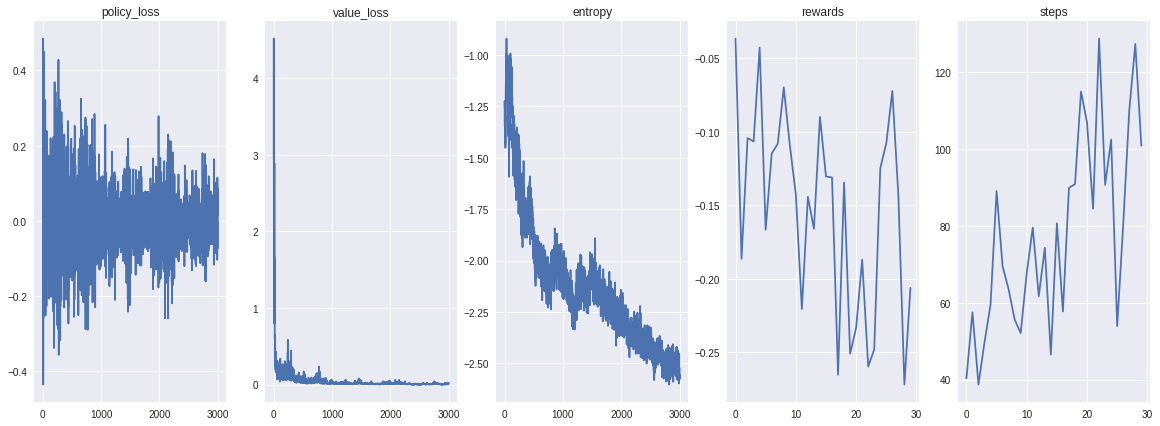

In [88]:


input_shape  = envs.observation_space.shape[0]
output_shape = envs.action_space.shape[0]
#print(input_shape)
#print(output_shape)
model = A2C_Conti(input_shape, output_shape)
optimizer = optim.Adam(params = model.parameters(),lr = 0.002)

max_frames   = 15000
frame_idx    = 0

actor_loss_list = []
value_loss_list = []
entropy_list = []

plot_rewards = []
step_distance = []
steps = 0
n_steps = 5

state = envs.reset()

while frame_idx < max_frames:
    
    action_batch = []
    mean_batch = []
    variance_batch = []
    values_batch    = []
    rewards_batch   = []
    masks     = []
    entropy = 0


    for _ in range(n_steps):
        state = torch.FloatTensor(state)
        mean, variance, value = model(state)
        #print(mean.shape)
        #print(variance.shape)
        #print(mean.data.numpy)
        
        action = calc_actions(mean, variance) 
        next_state, reward, done, _ = envs.step(action)
        
        action_batch.append(torch.FloatTensor(action))                # [nr_of_envs, 8]
        mean_batch.append(mean)                                       # [nr_of_envs, 8]
        variance_batch.append(variance)                               # [nr_of_envs, 8]
        values_batch.append(value)                                    # [nr_of_envs, 8]
        rewards_batch.append(torch.FloatTensor(reward).unsqueeze(1))  # appends vector in shape [nr_of_envs, 1]
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1))        # appends vector in shape [nr_of_envs, 1]
        
        #break  # for debugging
        
        state = next_state
        frame_idx += 1
          
        if frame_idx % 500 == 0:
            test_rewards, test_steps = test_net(model, env)
            step_distance.append(test_steps)
            plot_rewards.append(test_rewards)
    #break
    run_optimization(next_state, model,action_batch, mean_batch, variance_batch, values_batch, rewards_batch ,masks)
    #break
    
    
    

# PLOTTING RESULTS

plt.figure(figsize = (20,7))
plt.subplot(1,5,1)
plt.title("policy_loss")
plt.plot(actor_loss_list)
plt.subplot(1,5,2)
plt.title("value_loss")
plt.plot(value_loss_list)
plt.subplot(1,5,3)
plt.title("entropy")
plt.plot(entropy_list)
plt.subplot(1,5,4)
plt.title("rewards")
plt.plot(plot_rewards)
plt.subplot(1,5,5)
plt.title("steps")
plt.plot(step_distance)

**For multiprocessing**

In [0]:
from multiprocessing import Process, Pipe

def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close()
    env = env_fn_wrapper.x()
    while True:
        cmd, data = remote.recv()
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError

class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """
    def __init__(self, x):
        self.x = x
    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)
    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)
        

class VecEnv(object):
    """
    An abstract asynchronous, vectorized environment.
    """
    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a tuple of observation arrays.
        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.
        You should not call this if a step_async run is
        already pending.
        """
        pass

    def step_wait(self):
        """
        Wait for the step taken with step_async().
        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a tuple of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    def close(self):
        """
        Clean up the environments' resources.
        """
        pass

    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()

class SubprocVecEnv(VecEnv):
    def __init__(self, env_fns, spaces=None):
        """
        envs: list of gym environments to run in subprocesses
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.nenvs = nenvs
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, CloudpickleWrapper(env_fn)))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes:
            remote.close()

        self.remotes[0].send(('get_spaces', None))
        observation_space, action_space = self.remotes[0].recv()
        VecEnv.__init__(self, len(env_fns), observation_space, action_space)

    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:            
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
            self.closed = True
            
    def __len__(self):
        return self.nenvs